# 불균형 데이터를 대상으로 PCA 및 TSNE 기법을 적용한 예시
## Oversampling 기법 중 하나인 SMOTE 라이브러리 활용
* https://www.kaggle.com/sahilk1610/imbalanced-dataset-pca-t-sne/notebook

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
base_dir = '/content/drive/My Drive/Colab Notebooks/티스토리 공유 파일/모비스 코드/dataset/'
train = pd.read_csv(base_dir + 'pca_train.csv')
test = pd.read_csv(base_dir + 'pca_test.csv')

print(train.shape)
print(test.shape)

(1763, 1559)
(756, 1558)


0    1620
1     143
Name: Class, dtype: int64


(array([1620.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         143.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

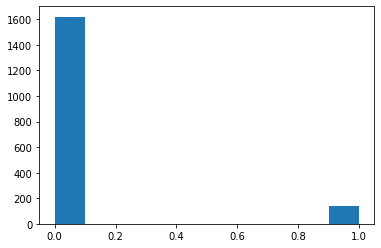

In [7]:
print(train['Class'].value_counts())
plt.hist(train['Class'])

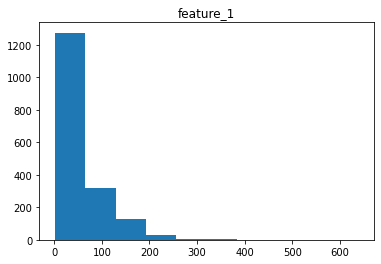

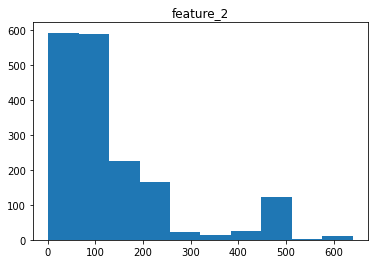

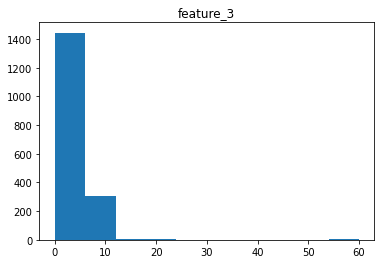

In [8]:
for i in train.columns[:3]:
    plt.hist(train[i])
    plt.title(i)
    plt.show()

# SMOTE 기법 활용
* Oversampling 방법 중 하나로 KNN 기반으로 작동
* 즉, 빈도가 적은 클래스의 데이터 인스턴스를 KNN 거리에 따라 가상의 데이터 생성

In [9]:
Sm = SMOTE()
X = train.drop('Class', axis=1)
y = train['Class']

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1586, 1558), (177, 1558), (1586,), (177,))

In [15]:
x_train, y_train = Sm.fit_resample(X_train, y_train)
x_train.shape, y_train.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((2914, 1558), (2914,))

In [17]:
from collections import Counter
# 0과 1 빈도수 파악하기
Counter(y_train)

Counter({0: 1457, 1: 1457})

In [18]:
x_train_re, x_valid_re, y_train_re, y_valid_re = train_test_split(x_train, y_train, test_size = 0.1, stratify = y_train)

In [20]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 32 kB/s 


In [21]:
from sklearn.ensemble import RandomForestClassifier
import catboost
from sklearn.metrics import auc, roc_curve

In [22]:
def metric(preds, target):
    fpr, tpr, thresholds = roc_curve(target, preds)
    return auc(fpr, tpr)

In [23]:
Rf = RandomForestClassifier()
model_Rf = Rf.fit(x_train_re, y_train_re)
preds = model_Rf.predict(x_valid_re)
print(metric(preds, y_valid_re))

0.9315068493150684


# PCA 적용

In [24]:
# 3차원으로 축소
pca = PCA(n_components=3, random_state=52)

In [25]:
pca_result = pca.fit_transform(X) # 3차원으로 축소했을 때 값들
print(pca_result)

# 설명된 분산 비율
print(pca.explained_variance_ratio_) # 87%, 13%, 0.05%

[[ 41.29209609  40.1789675   -0.87088813]
 [-48.82113906 -24.73211437   0.45482889]
 [ 31.27588583  40.99439402  -0.74983198]
 ...
 [ 97.62158049  25.80036249  -1.73416577]
 [-51.49762936 -28.3396795    1.31139638]
 [-87.29227957  -1.32769941  -0.92771851]]
[8.66775545e-01 1.32078413e-01 5.75164405e-04]


In [26]:
# 3개 변수 각각 살펴보기
train_copy = train.copy()
train_copy['pca-one'] = pca_result[:, 0]
train_copy['pca-two'] = pca_result[:, 1]
train_copy['pca-three'] = pca_result[:, 2]

## PCA 2차원 그래프 생성

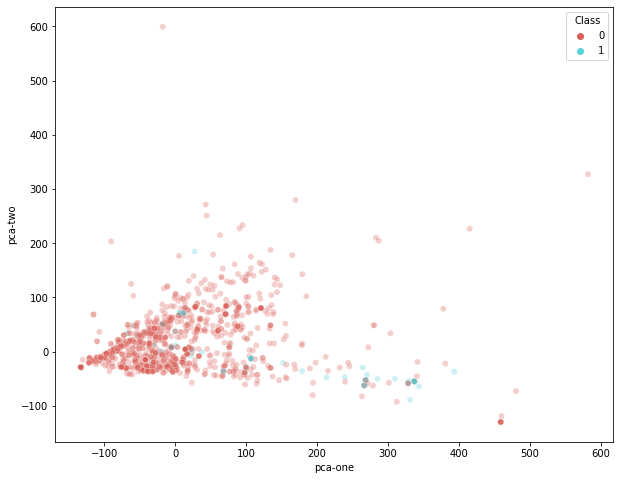

In [27]:
rndperm = np.random.permutation(train_copy.shape[0]) # 1763개 데이터 random shuffle하는 것과 동일
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca-one', y='pca-two',
    hue='Class',
    palette=sns.color_palette('hls', 2),
    data=train_copy.loc[rndperm, :],
    legend='full',
    alpha=0.3
)

## PCA 3차원 그래프 생성

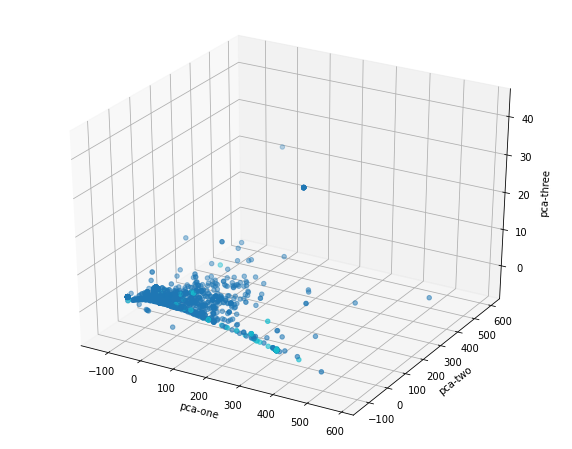

In [28]:
ax = plt.figure(figsize=(10, 8)).gca(projection='3d')
ax.scatter(
    xs=train_copy.loc[rndperm, :]['pca-one'],
    ys=train_copy.loc[rndperm, :]['pca-two'],
    zs=train_copy.loc[rndperm, :]['pca-three'],
    c=train_copy.loc[rndperm, :]['Class'],
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# TSNE 적용

In [29]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300) # perplexity: 값이 크면 더 많은 이웃을 포함하여 작은 그룹 무시(default=30)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1763 samples in 0.278s...
[t-SNE] Computed neighbors for 1763 samples in 2.650s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1763
[t-SNE] Computed conditional probabilities for sample 1763 / 1763
[t-SNE] Mean sigma: 2.357677
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.578796
[t-SNE] KL divergence after 300 iterations: 0.637976
CPU times: user 11.5 s, sys: 2.18 ms, total: 11.6 s
Wall time: 7.44 s


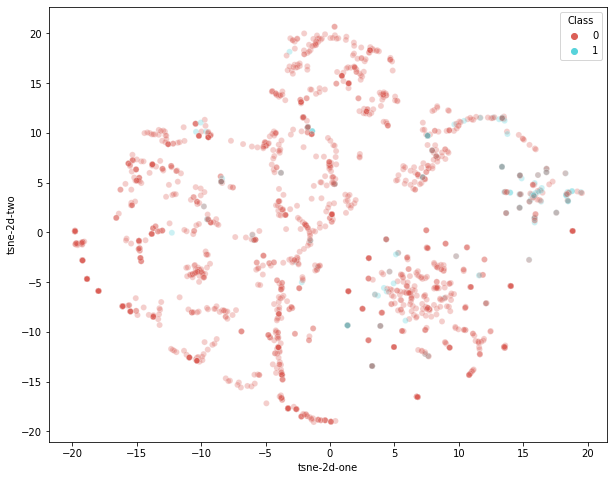

In [30]:
train_copy['tsne-2d-one'] = tsne_results[:, 0]
train_copy['tsne-2d-two'] = tsne_results[:, 1]
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='Class',
    palette=sns.color_palette('hls', 2),
    data=train_copy,
    legend='full',
    alpha=0.3
)

In [31]:
# 50차원으로 축소
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(X)
print('50차원의 누적 설명 분산은: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

50차원의 누적 설명 분산은: 0.9997639138462288


In [32]:
# 시간 다소 소요
%%time
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
tsne_pca_results = tsne.fit_transform(pca_result_50)

CPU times: user 26.2 s, sys: 118 ms, total: 26.4 s
Wall time: 13.6 s


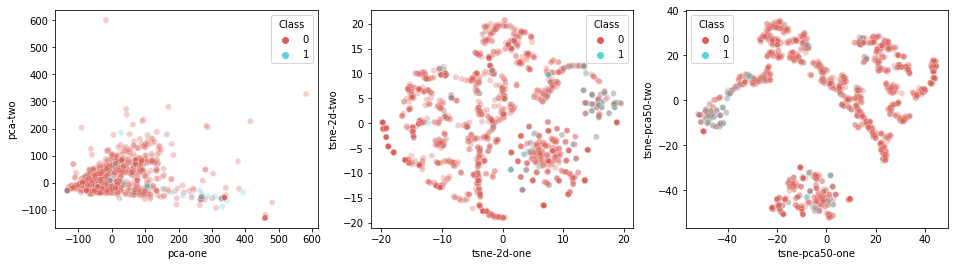

In [33]:
train_copy['tsne-pca50-one'] = tsne_pca_results[:,0]
train_copy['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Class",
    palette=sns.color_palette("hls", 2),
    data=train_copy,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Class",
    palette=sns.color_palette("hls", 2),
    data=train_copy,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="Class",
    palette=sns.color_palette("hls", 2),
    data=train_copy,
    legend="full",
    alpha=0.3,
    ax=ax3
)